In [1]:
cd ../

/Users/sam/Documents/GitHub/evcomplex-scoring


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# "bioviper" provides easier functionality for working with Biopython classes
from bioviper import msa, pdb

# To work directly with EVcouplings DCA models
from evcouplings.couplings import CouplingsModel
from ete3 import NCBITaxa
from sklearn.mixture import GaussianMixture

from score import score_sequences

# So that saved pdfs have editable text
plt.rcParams["pdf.fonttype"] = "TrueType"

In [3]:
%matplotlib ipympl
from mpl_interactions import interactive_hist

In [4]:
tp2_model = CouplingsModel('/Users/sam/Documents/dca_models/murA_lpxC_cheat.model')

tp2_couplings = \
    pd.read_csv("coupling_scores/true_positive_top_2_CouplingScores_inter.csv")

In [5]:
murA_ali = msa.readAlignment("alignments/murA_init_align_1.a2m")
print("murA alignment has", murA_ali.N, "sequences and", murA_ali.L, 'positions')

lpxC_ali = msa.readAlignment("alignments/lpxC_init_align_2.a2m")
print("lpxC alignment has", lpxC_ali.N, "sequences and", lpxC_ali.L, 'positions')

murA_lpxC_concat_ali = msa.readAlignment("alignments/murA_lpxC_concatenated_full.a2m")
print("Concatenated alignment has", murA_lpxC_concat_ali.N, "sequences and", 
                                    murA_lpxC_concat_ali.L, 'positions')

concat_ali_ids = murA_lpxC_concat_ali.ids[1:]

murA_sequences_in_cat_ali = [murA_ali.ids[0]] + ['_'.join(i.split('_')[:2]) for i in concat_ali_ids]
lpxC_sequences_in_cat_ali = [lpxC_ali.ids[0]] + ['_'.join(i.split('_')[2:]) for i in concat_ali_ids]

murA_ali = msa.MultipleSequenceAlignment([murA_ali[seq] for seq in murA_sequences_in_cat_ali]).standardize()
lpxC_ali = msa.MultipleSequenceAlignment([lpxC_ali[seq] for seq in lpxC_sequences_in_cat_ali]).standardize()

murA alignment has 54940 sequences and 421 positions
lpxC alignment has 23634 sequences and 303 positions
Concatenated alignment has 11834 sequences and 724 positions


In [7]:
Scores = []; Ks = []; Kp = []

for i in range(1, 50):
    
    s, ks, kp = score_sequences(tp2_model, murA_ali, lpxC_ali, tp2_couplings, i)
    Scores.append(s)

Kept 1 out of 1 pairs and 11782 out of 11834 sequences
Kept 2 out of 2 pairs and 11669 out of 11834 sequences
Kept 3 out of 3 pairs and 11048 out of 11834 sequences
Kept 4 out of 4 pairs and 11044 out of 11834 sequences
Kept 5 out of 5 pairs and 11004 out of 11834 sequences
Kept 6 out of 6 pairs and 11003 out of 11834 sequences
Kept 7 out of 7 pairs and 11000 out of 11834 sequences
Kept 8 out of 8 pairs and 10997 out of 11834 sequences
Kept 9 out of 9 pairs and 10996 out of 11834 sequences
Kept 10 out of 10 pairs and 10996 out of 11834 sequences
Kept 11 out of 11 pairs and 10994 out of 11834 sequences
Kept 12 out of 12 pairs and 10992 out of 11834 sequences
Kept 13 out of 13 pairs and 10973 out of 11834 sequences
Kept 14 out of 14 pairs and 10972 out of 11834 sequences
Kept 15 out of 15 pairs and 10964 out of 11834 sequences
Kept 16 out of 16 pairs and 10964 out of 11834 sequences
Kept 17 out of 17 pairs and 10964 out of 11834 sequences
Kept 18 out of 18 pairs and 10960 out of 11834 se

(0.0, 2000.0)

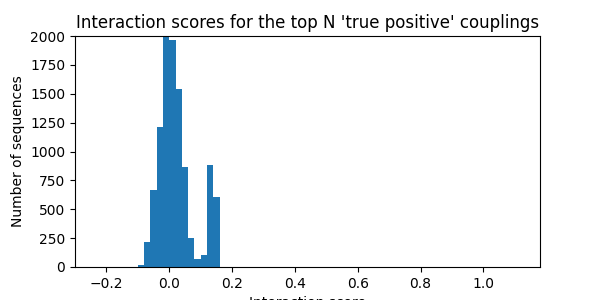

In [8]:
%matplotlib ipympl

def scores_indexer(n):
    return np.sum(Scores[n],axis=1)

fig, ax = plt.subplots(figsize=(6,3))
controls = interactive_hist(scores_indexer, n=np.arange(1,48,1), bins=np.arange(-0.3, 1.2, 0.02))

plt.xlabel("Interaction score")
plt.ylabel("Number of sequences")

plt.title("Interaction scores for the top N 'true positive' couplings")

plt.ylim((0,2000))

Below is the plot just for using the top N=20 top couplings, which is what we use for the "interaction scores" in the paper. This number is a bit arbitrary but our findings are pretty similar for slightly different choices of the number of couplings! (e.g. I think it's best to use >1 or 2 and less than 50 or so)

Kept 19 out of 20 pairs and 11577 out of 11834 sequences


Text(0, 0.5, 'Number of sequences')

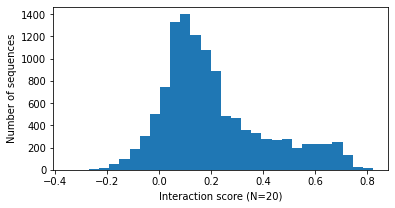

In [45]:
%matplotlib inline

score20, keep_s_20, keep_p_20 = score_sequences(tp2_model, murA_ali, lpxC_ali, tp2_couplings, 20, p_thresh=0.98)

plt.figure(figsize=(6,3))
plt.hist(np.sum(score20,axis=1), bins=30)

plt.xlabel("Interaction score (N=20)")
plt.ylabel("Number of sequences")

## Mapping sequences to their respective class

We want to be able to identify which sequences come from particular classes - in this case, we're especially interested in finding which ones come from delta- and alphaproteobacteria.

In [40]:
ncbi = NCBITaxa()

def loadTaxonomyLineage(tax_ids):
    
    '''
    Given a list of TaxIDs, load the full taxonomic information for each sequence.
    
    Adapted from code written originally by Nikki Thadani.
    '''
    
    tax_ranks = ['superkingdom','phylum','genus','class','subphylum','family','order', 'species']
    
    taxs = []

    for tax_id in tax_ids:
        try:
            lineage = ncbi.get_lineage(int(tax_id))
            name_dict = ncbi.get_taxid_translator(lineage)
            rank_dict = ncbi.get_rank(lineage)
            lineage_dict = dict((rank_dict[i],name_dict[i]) for i in lineage)
    
            lineage_dict = {k:lineage_dict[k] for k in tax_ranks if k in lineage_dict}
        
            lineage_dict['tax_ID'] = tax_id
            
            taxs.append(lineage_dict)
            
        except ValueError as e:
            print('Warning: {0}'.format(str(e)))
            
    return pd.DataFrame(taxs)

In [41]:
# Load in the csv with the annotations (including taxonomy) for each sequence
murA_annotation = pd.read_csv('annotation/murA_annotation.csv', index_col='id')

# Extract only the numeric taxid from each sequence
taxids = [int(i.split("TaxID=")[1]) for i in list(murA_annotation["Tax"])[1:] if '/' not in i]

# Load the full lineage associated with those taxonomic identifiers
taxid_mapper = loadTaxonomyLineage(taxids)

# Display
taxid_mapper

,superkingdom,phylum,species,tax_ID,genus,class,family,order,subphylum
0,Bacteria,Firmicutes,Firmicutes bacterium,1879010,NaN,NaN,NaN,NaN,NaN
1,Bacteria,Firmicutes,Caminicella sporogenes,1121266,Caminicella,Clostridia,Clostridiaceae,Eubacteriales,NaN
2,Bacteria,Firmicutes,Paramaledivibacter caminithermalis,1121301,Paramaledivibacter,Clostridia,Clostridiaceae,Eubacteriales,NaN
3,Bacteria,Firmicutes,Desulfotomaculum nigrificans,1565,Desulfotomaculum,Clostridia,Desulfotomaculaceae,Eubacteriales,NaN
4,Bacteria,Firmicutes,Caloramator mitchellensis,908809,Caloramator,Clostridia,Clostridiaceae,Eubacteriales,NaN
...,...,...,...,...,...,...,...,...,...
54002,Bacteria,Candidatus Woesebacteria,Candidatus Woesebacteria bacterium CG_4_10_14_...,1975054,NaN,NaN,NaN,NaN,NaN
54003,Bacteria,Candidatus Saccharibacteria,Candidatus Saccharimonas sp.,1917697,Candidatus Saccharimonas,Candidatus Saccharimonadia,Candidatus Saccharimonadaceae,Candidatus Saccharimonadales,NaN
54004,Bacteria,Chloroflexi,Caldilineae bacterium,2420332,NaN,Caldilineae,NaN,NaN,NaN
54005,Bacteria,Proteobacteria,Sphingomonas sp. LH128,473781,Sphingomonas,Alphaproteobacteria,Sphingomonadaceae,Sphingomonadales,NaN


Identify the class for each sequence that was scored:

In [28]:
classes = []

for i in murA_annotation.loc[murA_ali.ids[keep_s_20]]["Tax"][1:]:
    x = i.split("TaxID=")[1]
    try:
        x = int(x)
        y = list(taxid_mapper.loc[taxid_mapper["tax_ID"]==x]["class"])
        classes.append(y[0])
        
    except:
        classes.append('nan')

In [38]:
unique_classes, class_counts = np.unique(classes, return_counts=True)
pd.DataFrame(zip(unique_classes[class_counts > 50], class_counts[class_counts > 50]), columns=("Class", "Counts")).set_index("Class")


,Counts
Class,
Alphaproteobacteria,2459
Bacteroidia,435
Betaproteobacteria,1470
Chitinophagia,130
Cytophagia,325
Deltaproteobacteria,321
Epsilonproteobacteria,367
Flavobacteriia,1005
Fusobacteriia,55


How do these divide up among clades?

<AxesSubplot:xlabel='Interaction score', ylabel='Density'>

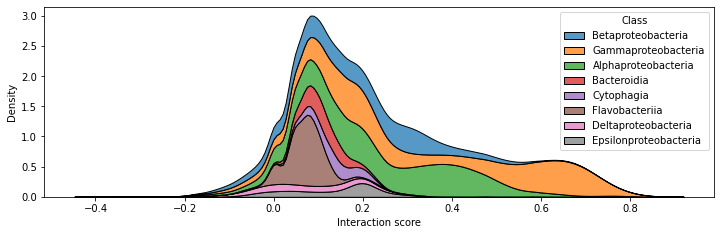

In [123]:
# Leave out the last one, which will be 'nan'
in_major_clades = np.isin(classes, unique_classes[class_counts > 250][:-1])

plt.figure(figsize=(12,3.5))
X = pd.DataFrame(zip(scores[1:][A], np.array(classes)[A]), columns=("Interaction score", "Class"))

sns.kdeplot(data=X, x="Interaction score", hue="Class", fill=True, multiple="stack")

Fit a Gaussian mixture model to the distribution with any arbitrary number of Gaussians:

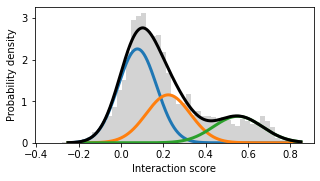

In [135]:
n = 3 # Can re-set the number of Gaussians to fit

def gaussian(x,mu,var):
    
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-(x-mu)**2/2/var)

# Define the scores
    # GaussianMixture needs them to be in this very silly shape as below
scores = np.sum(score20,axis=1).reshape(len(score20), -1)

# Initialize a two component Gaussian mixture model
gmm = GaussianMixture(n); gmm.fit(scores)

mu = gmm.means_.reshape(n)
w = gmm.weights_.reshape(n)
var = gmm.covariances_.reshape(n)

gaussians = []
for k in range(n):
    gaussians.append(lambda x: gaussian(x, mu[k], var[k]))
    
x = np.linspace(-0.25, 0.85, 1000)

plt.figure(figsize=(5,2.5))
plt.hist(scores, density=True, color='lightgray', bins=50)
for k in range(n):
    plt.plot(x, gaussians[k](x)*w[k], lw=3)
    
full_dist = 0
for k in range(n):
    full_dist += gaussians[k](x) * w[k]
    
plt.plot(x, full_dist, c='k', lw=3)

plt.xlabel("Interaction score")
plt.ylabel("Probability density")

plt.savefig("interaction_score_mixture_model.pdf", bbox_inches='tight')

Here's my "actual" code for the 2-component Gaussian mixture (basically the same as the above)

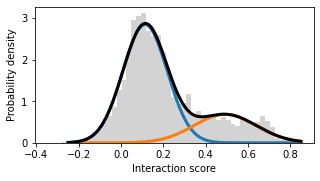

In [165]:
# Initialize a two component Gaussian mixture model
gmm2 = GaussianMixture(2); gmm2.fit(scores)

mu = gmm2.means_.reshape(2)
w = gmm2.weights_.reshape(2)
var = gmm2.covariances_.reshape(2)

gauss_1 = lambda x: gaussian(x, mu[0], var[0])
gauss_2 = lambda x: gaussian(x, mu[1], var[1])

x = np.linspace(-0.25, 0.85, 1000)

plt.figure(figsize=(5,2.5))
plt.hist(scores, density=True, color='lightgray', bins=50)
plt.plot(x, gauss_1(x)*w[0], lw=3)
plt.plot(x, gauss_2(x)*w[1], lw=3)
plt.plot(x, gauss_1(x)*w[0] + gauss_2(x)*w[1], c='k', lw=3)

plt.xlabel("Interaction score")
plt.ylabel("Probability density")

plt.savefig("interaction_score_mixture_model.pdf", bbox_inches='tight')

I now want to calculate the posterior probability of each sequence pair being in the upper Gaussian. While it's trivial to extract the assigned probability value, this isn't enough. I'll use Bayes' rule:

$$ p(G_2 | S=s) = \frac{p(S=s | G_2) p(G_2)}{p(S=s)}$$

$p(G_2)$ is just $w_2$, while $p(S=s)$ is the total probability assigned by the mixture model.

A quick note about this: compared to just assigning each point to the mixture component that assigns a higher probability, this will downweight the "upper" Gaussian slightly based on the *prior* expectation that it's more likely for a random sequence of unknwon interaction score to be in the lower Gaussian than the upper one.

In [166]:
# The posterior probability of being in Gaussian #2 by Bayes' rule
post_p = gauss_2(scores).T[0] * w[1] / (w[0] * gauss_1(scores).T[0] + w[1] * gauss_2(scores).T[0])

If we assume that each sequence pair is independently drawn, the overall expected value for the fraction of interacting sequences in a class will be the average posterior probability of being in Gaussian #2 across the class by the Central Limit Theorem.

Note that because of phylogeny they are of course *not* truely independent, so this isn't entirely accurate, but it's hard to make any other specific assumptions here.

In [167]:
tax = 'Gammaproteobacteria'
w = np.where(np.array(classes)==tax)[0]
print("Expected fraction of interacting gammaproteobacteria", np.mean(post_p[w]))

tax = 'Alphaproteobacteria'
w = np.where(np.array(classes)==tax)[0]
print("Expected fraction of interacting alphaproteobacteria", np.mean(post_p[w]))

Expected fraction of interacting gammaproteobacteria 0.48500070316257293
Expected fraction of interacting alphaproteobacteria 0.3542852865344349
